In [5]:
# Cell 1: Installer les dépendances
!pip install optuna keras-tuner keras-tcn
!pip install optuna-integration[keras]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.1 MB/s eta 0:00:00a 0:00:01


In [7]:
# Cell 2: Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten, Dense, Dropout,
    GRU, SimpleRNN, Input, MultiHeadAttention, LayerNormalization, Add
)
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from optuna.integration import KerasPruningCallback
from tcn import TCN
from keras_tuner.tuners import Hyperband


In [19]:
# Cell 3 corrigée : Chargement et nettoyage des données
file_path = '/kaggle/input/dataset-ts/Padded Data TS Morocco.csv'
df = pd.read_csv(file_path)

# Renommer la première colonne en 'date'
df.rename(columns={df.columns[0]: 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)




# 2) Nettoyer les colonnes numériques
num_cols = df.columns
df[num_cols] = (
    df[num_cols]
      .replace({' ': '', '\xa0': ''}, regex=True)
      .astype(float)
)

# 3) Imputation des valeurs manquantes
df.ffill(inplace=True)   # forward-fill
df.bfill(inplace=True)   # back-fill pour combler les NaN initiaux


In [21]:
# Cell 4: Split chronologique train / val / test
n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]


In [22]:
# Cell 5: Scaling (fit sur train uniquement)
scaler = MinMaxScaler()
scaler.fit(train_df)

train_scaled = scaler.transform(train_df)
val_scaled   = scaler.transform(val_df)
test_scaled  = scaler.transform(test_df)


In [23]:
# Cell 6: Création des séquences temporelles
SEQ_LEN = 30

def create_sequences(data, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_val,   y_val   = create_sequences(np.vstack([train_scaled[-SEQ_LEN:], val_scaled]))
X_test,  y_test  = create_sequences(np.vstack([val_scaled[-SEQ_LEN:], test_scaled]))


In [24]:
# Cell 7: Walk-Forward CV utilitaire
def walk_forward_cv(X, y, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, test_idx in tscv.split(X):
        yield X[train_idx], y[train_idx], X[test_idx], y[test_idx]


In [26]:
# Cell 8: Tuning LSTM amélioré avec Optuna

import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error

# Nombre de features à prévoir
n_features = X_train.shape[2]

def build_lstm_model(trial):
    units    = trial.suggest_int("units", 32, 256)
    dropout  = trial.suggest_float("dropout", 0.0, 0.5)
    n_layers = trial.suggest_int("n_layers", 1, 3)

    model = Sequential()
    # Définition de l'input
    model.add(Input(shape=(SEQ_LEN, n_features)))

    # Empilement des LSTM + Dropout
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)
        model.add(LSTM(units, return_sequences=return_seq))
        model.add(Dropout(dropout))

    # Prédiction de dimension n_features
    model.add(Dense(n_features, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

def objective_lstm(trial):
    cv_scores = []
    # Walk-forward CV
    for split_idx, (X_tr, y_tr, X_te, y_te) in enumerate(walk_forward_cv(X_train, y_train), start=1):
        model = build_lstm_model(trial)
        # EarlyStopping uniquement
        model.fit(
            X_tr, y_tr,
            validation_data=(X_te, y_te),
            epochs=50, batch_size=32,
            callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
            verbose=0
        )
        preds = model.predict(X_te)
        score = mean_squared_error(y_te, preds)

        # Reporting + pruning manuel
        trial.report(score, split_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

        cv_scores.append(score)

    return float(np.mean(cv_scores))

# Lancement de l'optimisation
study_lstm = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner()
)
study_lstm.optimize(objective_lstm, n_trials=30)

# Récupération des meilleurs paramètres
best_params_lstm = study_lstm.best_trial.params
print("Meilleurs hyperparamètres LSTM :", best_params_lstm)


[I 2025-05-05 01:04:07,844] A new study created in memory with name: no-name-40b706e4-001a-4b34-99e5-b9a54700aef3


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-05-05 01:04:26,149] Trial 0 finished with value: 0.020715698688391626 and parameters: {'units': 103, 'dropout': 0.008851331793721329, 'n_layers': 2}. Best is trial 0 with value: 0.020715698688391626.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[I 2025-05-05 01:04:45,829] Trial 1 finished with value: 0.02001381424606723 and parameters: {'units': 170, 'dropout': 0.4647361619214923, 'n_layers': 2}. Best is trial 1 with value: 0.02001381424606723.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step


[I 2025-05-05 01:05:11,993] Trial 2 finished with value: 0.01856806506571193 and parameters: {'units': 228, 'dropout': 0.4214165987505493, 'n_layers': 3}. Best is trial 2 with value: 0.01856806506571193.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step


[I 2025-05-05 01:05:32,121] Trial 3 finished with value: 0.021015060596335094 and parameters: {'units': 104, 'dropout': 0.4269204159463875, 'n_layers': 2}. Best is trial 2 with value: 0.01856806506571193.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


[I 2025-05-05 01:05:48,145] Trial 4 finished with value: 0.022783889454773252 and parameters: {'units': 198, 'dropout': 0.4715288129331534, 'n_layers': 2}. Best is trial 2 with value: 0.01856806506571193.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-05 01:06:01,389] Trial 5 finished with value: 0.01741628363990987 and parameters: {'units': 245, 'dropout': 0.1503938535666699, 'n_layers': 1}. Best is trial 5 with value: 0.01741628363990987.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-05 01:06:20,502] Trial 6 finished with value: 0.02094797323223597 and parameters: {'units': 94, 'dropout': 0.11090583113320052, 'n_layers': 2}. Best is trial 5 with value: 0.01741628363990987.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-05 01:06:32,593] Trial 7 finished with value: 0.017816150982991247 and parameters: {'units': 145, 'dropout': 0.04703079792844156, 'n_layers': 1}. Best is trial 5 with value: 0.01741628363990987.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-05 01:06:43,470] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-05 01:06:52,154] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


[I 2025-05-05 01:06:59,308] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-05 01:07:12,821] Trial 11 finished with value: 0.017968010233527093 and parameters: {'units': 254, 'dropout': 0.12641668878691675, 'n_layers': 1}. Best is trial 5 with value: 0.01741628363990987.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-05 01:07:25,776] Trial 12 finished with value: 0.01753660327205542 and parameters: {'units': 145, 'dropout': 0.012594667013087618, 'n_layers': 1}. Best is trial 5 with value: 0.01741628363990987.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 721ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-05 01:07:39,952] Trial 13 finished with value: 0.018941681500364654 and parameters: {'units': 181, 'dropout': 0.21828994118928902, 'n_layers': 1}. Best is trial 5 with value: 0.01741628363990987.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-05 01:07:44,117] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-05 01:07:52,874] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-05 01:08:06,328] Trial 16 finished with value: 0.01903835798904552 and parameters: {'units': 213, 'dropout': 0.04955086067798797, 'n_layers': 1}. Best is trial 5 with value: 0.01741628363990987.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


[I 2025-05-05 01:08:28,100] Trial 17 finished with value: 0.014535070087986041 and parameters: {'units': 255, 'dropout': 0.18136777349012154, 'n_layers': 2}. Best is trial 17 with value: 0.014535070087986041.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


[I 2025-05-05 01:08:35,843] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


[I 2025-05-05 01:08:41,785] Trial 19 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


[I 2025-05-05 01:08:56,907] Trial 20 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-05 01:09:00,077] Trial 21 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-05-05 01:09:04,837] Trial 22 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-05 01:09:08,114] Trial 23 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[I 2025-05-05 01:09:12,555] Trial 24 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-05 01:09:23,134] Trial 25 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-05-05 01:09:27,666] Trial 26 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-05 01:09:40,933] Trial 27 finished with value: 0.017516073015972508 and parameters: {'units': 170, 'dropout': 0.15462911395594217, 'n_layers': 1}. Best is trial 17 with value: 0.014535070087986041.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-05 01:09:47,102] Trial 28 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


[I 2025-05-05 01:09:54,997] Trial 29 pruned. 


Meilleurs hyperparamètres LSTM : {'units': 255, 'dropout': 0.18136777349012154, 'n_layers': 2}


In [27]:
# Cell 9: Tuning BiLSTM amélioré avec Optuna

from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error

def build_bilstm_model(trial):
    units    = trial.suggest_int("units", 32, 256)
    dropout  = trial.suggest_float("dropout", 0.0, 0.5)
    n_layers = trial.suggest_int("n_layers", 1, 3)

    model = Sequential()
    model.add(Input(shape=(SEQ_LEN, n_features)))

    for i in range(n_layers):
        return_seq = (i < n_layers - 1)
        model.add(Bidirectional(LSTM(units, return_sequences=return_seq)))
        model.add(Dropout(dropout))

    model.add(Dense(n_features, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

def objective_bilstm(trial):
    cv_scores = []
    for split_idx, (X_tr, y_tr, X_te, y_te) in enumerate(walk_forward_cv(X_train, y_train), start=1):
        model = build_bilstm_model(trial)
        model.fit(
            X_tr, y_tr,
            validation_data=(X_te, y_te),
            epochs=50, batch_size=32,
            callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
            verbose=0
        )
        preds = model.predict(X_te)
        score = mean_squared_error(y_te, preds)

        trial.report(score, split_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_bilstm = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study_bilstm.optimize(objective_bilstm, n_trials=30)
best_params_bilstm = study_bilstm.best_trial.params
print("Meilleurs hyperparamètres BiLSTM :", best_params_bilstm)


[I 2025-05-05 01:12:00,210] A new study created in memory with name: no-name-c029d337-f5f7-466b-9366-49dc43be0753


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


[I 2025-05-05 01:12:28,120] Trial 0 finished with value: 0.018916283364284383 and parameters: {'units': 78, 'dropout': 0.3825353678758686, 'n_layers': 2}. Best is trial 0 with value: 0.018916283364284383.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step


[I 2025-05-05 01:13:09,695] Trial 1 finished with value: 0.019323078231798248 and parameters: {'units': 160, 'dropout': 0.45935726402394783, 'n_layers': 3}. Best is trial 0 with value: 0.018916283364284383.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2025-05-05 01:13:38,075] Trial 2 finished with value: 0.012260506658926001 and parameters: {'units': 192, 'dropout': 0.02424191774271245, 'n_layers': 2}. Best is trial 2 with value: 0.012260506658926001.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step


[I 2025-05-05 01:14:17,847] Trial 3 finished with value: 0.018214191332583944 and parameters: {'units': 88, 'dropout': 0.2584361274144362, 'n_layers': 3}. Best is trial 2 with value: 0.012260506658926001.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


[I 2025-05-05 01:14:49,100] Trial 4 finished with value: 0.014482769151844939 and parameters: {'units': 52, 'dropout': 0.06079562494632107, 'n_layers': 2}. Best is trial 2 with value: 0.012260506658926001.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


[I 2025-05-05 01:15:18,374] Trial 5 finished with value: 0.014797417108567324 and parameters: {'units': 207, 'dropout': 0.3276727886467847, 'n_layers': 2}. Best is trial 2 with value: 0.012260506658926001.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2025-05-05 01:15:38,971] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step


[I 2025-05-05 01:15:50,643] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


[I 2025-05-05 01:15:55,051] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


[I 2025-05-05 01:16:01,757] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


[I 2025-05-05 01:16:09,401] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


[I 2025-05-05 01:16:17,516] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 01:16:24,798] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


[I 2025-05-05 01:16:55,218] Trial 13 finished with value: 0.012509249898553239 and parameters: {'units': 189, 'dropout': 0.11636695490339591, 'n_layers': 2}. Best is trial 2 with value: 0.012260506658926001.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 01:17:26,907] Trial 14 finished with value: 0.012572009324874655 and parameters: {'units': 195, 'dropout': 0.1547322609710336, 'n_layers': 2}. Best is trial 2 with value: 0.012260506658926001.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


[I 2025-05-05 01:17:31,548] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step


[I 2025-05-05 01:17:44,118] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2025-05-05 01:18:03,629] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step


[I 2025-05-05 01:18:18,042] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


[I 2025-05-05 01:18:22,703] Trial 19 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 01:18:31,015] Trial 20 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-05-05 01:18:41,432] Trial 21 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2025-05-05 01:18:48,667] Trial 22 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-05-05 01:19:06,215] Trial 23 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 01:19:29,170] Trial 24 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


[I 2025-05-05 01:19:58,676] Trial 25 finished with value: 0.015665969020370412 and parameters: {'units': 202, 'dropout': 0.08335885551946956, 'n_layers': 2}. Best is trial 2 with value: 0.012260506658926001.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step


[I 2025-05-05 01:20:08,479] Trial 26 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


[I 2025-05-05 01:20:13,757] Trial 27 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step


[I 2025-05-05 01:20:25,219] Trial 28 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


[I 2025-05-05 01:20:45,260] Trial 29 pruned. 


Meilleurs hyperparamètres BiLSTM : {'units': 192, 'dropout': 0.02424191774271245, 'n_layers': 2}


In [28]:
# Cell 10: Tuning LSTM-CNN amélioré avec Optuna

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, Dense

def build_lstm_cnn_model(trial):
    lstm_units  = trial.suggest_int("lstm_units", 32, 256)
    cnn_filters = trial.suggest_int("cnn_filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(SEQ_LEN, n_features))
    x   = LSTM(lstm_units, return_sequences=True)(inp)
    x   = Conv1D(cnn_filters, kernel_size, activation="relu")(x)
    x   = MaxPooling1D()(x)
    x   = Flatten()(x)
    x   = Dropout(dropout)(x)
    out = Dense(n_features, activation="linear")(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer="adam", loss="mse")
    return model

def objective_lstm_cnn(trial):
    cv_scores = []
    for split_idx, (X_tr, y_tr, X_te, y_te) in enumerate(walk_forward_cv(X_train, y_train), start=1):
        model = build_lstm_cnn_model(trial)
        model.fit(
            X_tr, y_tr,
            validation_data=(X_te, y_te),
            epochs=50, batch_size=32,
            callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
            verbose=0
        )
        preds = model.predict(X_te)
        score = mean_squared_error(y_te, preds)

        trial.report(score, split_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_lstm_cnn = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study_lstm_cnn.optimize(objective_lstm_cnn, n_trials=30)
best_params_lstm_cnn = study_lstm_cnn.best_trial.params
print("Meilleurs hyperparamètres LSTM-CNN :", best_params_lstm_cnn)


[I 2025-05-05 01:20:45,271] A new study created in memory with name: no-name-ee477b0e-3f19-47af-bf85-03a13b36ca9e


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 01:21:02,142] Trial 0 finished with value: 0.011659267041606212 and parameters: {'lstm_units': 233, 'cnn_filters': 124, 'kernel_size': 4, 'dropout': 0.47057804840343914}. Best is trial 0 with value: 0.011659267041606212.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-05 01:21:23,349] Trial 1 finished with value: 0.012242849588434192 and parameters: {'lstm_units': 187, 'cnn_filters': 31, 'kernel_size': 5, 'dropout': 0.2126143533029835}. Best is trial 0 with value: 0.011659267041606212.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-05 01:21:36,478] Trial 2 finished with value: 0.012722909628201204 and parameters: {'lstm_units': 192, 'cnn_filters': 110, 'kernel_size': 5, 'dropout': 0.030419487775568188}. Best is trial 0 with value: 0.011659267041606212.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 01:21:52,230] Trial 3 finished with value: 0.01351335266402594 and parameters: {'lstm_units': 164, 'cnn_filters': 54, 'kernel_size': 5, 'dropout': 0.3577786820324286}. Best is trial 0 with value: 0.011659267041606212.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-05 01:22:09,921] Trial 4 finished with value: 0.012708201978989203 and parameters: {'lstm_units': 184, 'cnn_filters': 119, 'kernel_size': 4, 'dropout': 0.4351651850946691}. Best is trial 0 with value: 0.011659267041606212.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-05 01:22:15,274] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-05 01:22:19,310] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-05 01:22:23,408] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-05 01:22:38,039] Trial 8 finished with value: 0.010728105696653637 and parameters: {'lstm_units': 120, 'cnn_filters': 90, 'kernel_size': 2, 'dropout': 0.057334673649731493}. Best is trial 8 with value: 0.010728105696653637.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 01:22:42,373] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-05 01:22:46,728] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-05 01:22:50,957] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-05 01:23:10,356] Trial 12 finished with value: 0.011097527214733937 and parameters: {'lstm_units': 112, 'cnn_filters': 83, 'kernel_size': 4, 'dropout': 0.31500945421500737}. Best is trial 8 with value: 0.010728105696653637.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-05 01:23:29,152] Trial 13 finished with value: 0.010914359667654236 and parameters: {'lstm_units': 100, 'cnn_filters': 78, 'kernel_size': 3, 'dropout': 0.3119028650796688}. Best is trial 8 with value: 0.010728105696653637.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-05 01:23:33,883] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-05 01:23:37,990] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-05 01:23:50,144] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 01:23:54,377] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-05-05 01:24:14,652] Trial 18 finished with value: 0.009827960328796579 and parameters: {'lstm_units': 81, 'cnn_filters': 73, 'kernel_size': 2, 'dropout': 0.006470393181420078}. Best is trial 18 with value: 0.009827960328796579.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-05 01:24:19,217] Trial 19 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-05-05 01:24:23,911] Trial 20 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-05 01:24:28,229] Trial 21 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-05 01:24:43,210] Trial 22 finished with value: 0.010844540661514463 and parameters: {'lstm_units': 136, 'cnn_filters': 85, 'kernel_size': 2, 'dropout': 0.0019141224947811439}. Best is trial 18 with value: 0.009827960328796579.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-05 01:24:47,630] Trial 23 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-05 01:25:03,454] Trial 24 finished with value: 0.01093908106285279 and parameters: {'lstm_units': 57, 'cnn_filters': 109, 'kernel_size': 2, 'dropout': 0.06793174908080225}. Best is trial 18 with value: 0.009827960328796579.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-05 01:25:07,646] Trial 25 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-05 01:25:12,224] Trial 26 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-05 01:25:31,108] Trial 27 finished with value: 0.010998567523528872 and parameters: {'lstm_units': 90, 'cnn_filters': 106, 'kernel_size': 3, 'dropout': 0.04425301216612352}. Best is trial 18 with value: 0.009827960328796579.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-05 01:25:35,731] Trial 28 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 01:25:39,881] Trial 29 pruned. 


Meilleurs hyperparamètres LSTM-CNN : {'lstm_units': 81, 'cnn_filters': 73, 'kernel_size': 2, 'dropout': 0.006470393181420078}


In [29]:
# Cell 11: Tuning GRU amélioré avec Optuna

from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

def build_gru_model(trial):
    units    = trial.suggest_int("units", 32, 256)
    dropout  = trial.suggest_float("dropout", 0.0, 0.5)
    n_layers = trial.suggest_int("n_layers", 1, 3)

    model = Sequential()
    model.add(Input(shape=(SEQ_LEN, n_features)))

    for i in range(n_layers):
        return_seq = (i < n_layers - 1)
        model.add(GRU(units, return_sequences=return_seq))
        model.add(Dropout(dropout))

    model.add(Dense(n_features, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

def objective_gru(trial):
    cv_scores = []
    for split_idx, (X_tr, y_tr, X_te, y_te) in enumerate(walk_forward_cv(X_train, y_train), start=1):
        model = build_gru_model(trial)
        model.fit(
            X_tr, y_tr,
            validation_data=(X_te, y_te),
            epochs=50, batch_size=32,
            callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
            verbose=0
        )
        preds = model.predict(X_te)
        score = mean_squared_error(y_te, preds)

        trial.report(score, split_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_gru = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study_gru.optimize(objective_gru, n_trials=30)
best_params_gru = study_gru.best_trial.params
print("Meilleurs hyperparamètres GRU :", best_params_gru)


[I 2025-05-05 01:25:39,892] A new study created in memory with name: no-name-553a8f34-897d-4737-a459-fe347b45914b


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-05 01:25:52,659] Trial 0 finished with value: 0.014685468780800593 and parameters: {'units': 79, 'dropout': 0.03573410022355589, 'n_layers': 1}. Best is trial 0 with value: 0.014685468780800593.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-05-05 01:26:15,458] Trial 1 finished with value: 0.017121990783460602 and parameters: {'units': 134, 'dropout': 0.28266765097515667, 'n_layers': 3}. Best is trial 0 with value: 0.014685468780800593.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-05 01:26:34,047] Trial 2 finished with value: 0.014241679928160602 and parameters: {'units': 76, 'dropout': 0.1541456602416812, 'n_layers': 1}. Best is trial 2 with value: 0.014241679928160602.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


[I 2025-05-05 01:26:51,319] Trial 3 finished with value: 0.013757387991990477 and parameters: {'units': 253, 'dropout': 0.44560640117188477, 'n_layers': 2}. Best is trial 3 with value: 0.013757387991990477.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[I 2025-05-05 01:27:06,920] Trial 4 finished with value: 0.015274601631746555 and parameters: {'units': 210, 'dropout': 0.10049807995329207, 'n_layers': 2}. Best is trial 3 with value: 0.013757387991990477.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[I 2025-05-05 01:27:12,288] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-05 01:27:16,392] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-05-05 01:27:43,441] Trial 7 finished with value: 0.01774380790780676 and parameters: {'units': 102, 'dropout': 0.18535847971479774, 'n_layers': 3}. Best is trial 3 with value: 0.013757387991990477.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


[I 2025-05-05 01:27:50,532] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[I 2025-05-05 01:27:55,995] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[I 2025-05-05 01:28:01,105] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-05 01:28:06,025] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-05 01:28:10,858] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-05 01:28:14,889] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[I 2025-05-05 01:28:21,378] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[I 2025-05-05 01:28:43,711] Trial 15 finished with value: 0.016156149927434495 and parameters: {'units': 165, 'dropout': 0.1907149621422538, 'n_layers': 2}. Best is trial 3 with value: 0.013757387991990477.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-05 01:28:48,390] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


[I 2025-05-05 01:28:56,640] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-05 01:29:00,079] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[I 2025-05-05 01:29:04,956] Trial 19 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-05 01:29:16,873] Trial 20 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-05 01:29:21,695] Trial 21 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-05 01:29:26,210] Trial 22 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-05 01:29:30,317] Trial 23 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-05 01:29:35,151] Trial 24 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-05 01:29:40,196] Trial 25 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-05 01:29:44,371] Trial 26 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-05-05 01:29:54,261] Trial 27 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[I 2025-05-05 01:30:00,953] Trial 28 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


[I 2025-05-05 01:30:09,039] Trial 29 pruned. 


Meilleurs hyperparamètres GRU : {'units': 253, 'dropout': 0.44560640117188477, 'n_layers': 2}


In [30]:
# Cell 12: Tuning RNN simple amélioré avec Optuna

from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense

def build_rnn_model(trial):
    units    = trial.suggest_int("units", 32, 256)
    dropout  = trial.suggest_float("dropout", 0.0, 0.5)
    n_layers = trial.suggest_int("n_layers", 1, 3)

    model = Sequential()
    model.add(Input(shape=(SEQ_LEN, n_features)))

    for i in range(n_layers):
        return_seq = (i < n_layers - 1)
        model.add(SimpleRNN(units, return_sequences=return_seq))
        model.add(Dropout(dropout))

    model.add(Dense(n_features, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

def objective_rnn(trial):
    cv_scores = []
    for split_idx, (X_tr, y_tr, X_te, y_te) in enumerate(walk_forward_cv(X_train, y_train), start=1):
        model = build_rnn_model(trial)
        model.fit(
            X_tr, y_tr,
            validation_data=(X_te, y_te),
            epochs=50, batch_size=32,
            callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
            verbose=0
        )
        preds = model.predict(X_te)
        score = mean_squared_error(y_te, preds)

        trial.report(score, split_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_rnn = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study_rnn.optimize(objective_rnn, n_trials=30)
best_params_rnn = study_rnn.best_trial.params
print("Meilleurs hyperparamètres RNN :", best_params_rnn)


[I 2025-05-05 01:30:09,051] A new study created in memory with name: no-name-c1085ed7-be74-4ab3-90ff-009a91ec210f
I0000 00:00:1746408613.438616     120 service.cc:148] XLA service 0x3227de30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746408613.439576     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746408616.247414     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step


[I 2025-05-05 01:30:56,190] Trial 0 finished with value: 0.03228573113297059 and parameters: {'units': 151, 'dropout': 0.20183388256298368, 'n_layers': 3}. Best is trial 0 with value: 0.03228573113297059.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


[I 2025-05-05 01:31:19,474] Trial 1 finished with value: 0.019356347905005105 and parameters: {'units': 145, 'dropout': 0.3380007002147184, 'n_layers': 1}. Best is trial 1 with value: 0.019356347905005105.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


[I 2025-05-05 01:32:14,855] Trial 2 finished with value: 0.023218562403809123 and parameters: {'units': 185, 'dropout': 0.20465061828507392, 'n_layers': 3}. Best is trial 1 with value: 0.019356347905005105.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step


[I 2025-05-05 01:33:06,128] Trial 3 finished with value: 0.024435075894693858 and parameters: {'units': 147, 'dropout': 0.47462554246074207, 'n_layers': 3}. Best is trial 1 with value: 0.019356347905005105.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


[I 2025-05-05 01:33:58,435] Trial 4 finished with value: 0.03183629260717963 and parameters: {'units': 57, 'dropout': 0.21573891581199345, 'n_layers': 3}. Best is trial 1 with value: 0.019356347905005105.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


[I 2025-05-05 01:34:20,591] Trial 5 finished with value: 0.01728948948129658 and parameters: {'units': 166, 'dropout': 0.03549781528810941, 'n_layers': 1}. Best is trial 5 with value: 0.01728948948129658.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


[I 2025-05-05 01:34:36,380] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step


[I 2025-05-05 01:34:46,845] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


[I 2025-05-05 01:34:54,662] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


[I 2025-05-05 01:35:18,631] Trial 9 finished with value: 0.01951488459614714 and parameters: {'units': 63, 'dropout': 0.0015129680339294183, 'n_layers': 1}. Best is trial 5 with value: 0.01728948948129658.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step


[I 2025-05-05 01:36:02,309] Trial 10 finished with value: 0.015995899421272167 and parameters: {'units': 241, 'dropout': 0.3199491427779471, 'n_layers': 2}. Best is trial 10 with value: 0.015995899421272167.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


[I 2025-05-05 01:36:25,681] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


[I 2025-05-05 01:36:50,568] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step


[I 2025-05-05 01:37:15,049] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


[I 2025-05-05 01:37:30,962] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step


[I 2025-05-05 01:37:54,241] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


[I 2025-05-05 01:38:09,909] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step


[I 2025-05-05 01:38:27,444] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


[I 2025-05-05 01:38:52,301] Trial 18 finished with value: 0.015001510998609358 and parameters: {'units': 225, 'dropout': 0.12196711753720735, 'n_layers': 1}. Best is trial 18 with value: 0.015001510998609358.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


[I 2025-05-05 01:39:02,392] Trial 19 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step


[I 2025-05-05 01:39:14,494] Trial 20 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


[I 2025-05-05 01:39:37,763] Trial 21 finished with value: 0.014440693578393447 and parameters: {'units': 181, 'dropout': 0.001742664524404955, 'n_layers': 1}. Best is trial 21 with value: 0.014440693578393447.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


[I 2025-05-05 01:39:59,042] Trial 22 finished with value: 0.01703050652699888 and parameters: {'units': 227, 'dropout': 0.16649975005513473, 'n_layers': 1}. Best is trial 21 with value: 0.014440693578393447.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


[I 2025-05-05 01:40:21,032] Trial 23 finished with value: 0.015426124067297148 and parameters: {'units': 189, 'dropout': 0.13418452125611208, 'n_layers': 1}. Best is trial 21 with value: 0.014440693578393447.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


[I 2025-05-05 01:40:36,151] Trial 24 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


[I 2025-05-05 01:41:00,144] Trial 25 finished with value: 0.015833027519575275 and parameters: {'units': 121, 'dropout': 0.0005766016181735568, 'n_layers': 1}. Best is trial 21 with value: 0.014440693578393447.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-05-05 01:41:20,453] Trial 26 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


[I 2025-05-05 01:41:42,760] Trial 27 finished with value: 0.015437533567841916 and parameters: {'units': 197, 'dropout': 0.06955577956103288, 'n_layers': 1}. Best is trial 21 with value: 0.014440693578393447.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


[I 2025-05-05 01:41:50,924] Trial 28 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


[I 2025-05-05 01:42:06,269] Trial 29 pruned. 


Meilleurs hyperparamètres RNN : {'units': 181, 'dropout': 0.001742664524404955, 'n_layers': 1}


In [31]:
# Cell 13: Tuning TCN amélioré avec Optuna

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tcn import TCN

def build_tcn_model(trial):
    filters     = trial.suggest_int("filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(SEQ_LEN, n_features))
    x   = TCN(nb_filters=filters, kernel_size=kernel_size, dilations=[1,2,4], dropout_rate=dropout)(inp)
    out = Dense(n_features, activation="linear")(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer="adam", loss="mse")
    return model

def objective_tcn(trial):
    cv_scores = []
    for split_idx, (X_tr, y_tr, X_te, y_te) in enumerate(walk_forward_cv(X_train, y_train), start=1):
        model = build_tcn_model(trial)
        model.fit(
            X_tr, y_tr,
            validation_data=(X_te, y_te),
            epochs=50, batch_size=32,
            callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
            verbose=0
        )
        preds = model.predict(X_te)
        score = mean_squared_error(y_te, preds)

        trial.report(score, split_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_tcn = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study_tcn.optimize(objective_tcn, n_trials=30)
best_params_tcn = study_tcn.best_trial.params
print("Meilleurs hyperparamètres TCN :", best_params_tcn)


[I 2025-05-05 01:42:06,280] A new study created in memory with name: no-name-8cf107b3-9fd7-42b5-8181-997852f14a53


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step


[I 2025-05-05 01:42:57,944] Trial 0 finished with value: 0.027592691831013 and parameters: {'filters': 56, 'kernel_size': 3, 'dropout': 0.35171260984358493}. Best is trial 0 with value: 0.027592691831013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-05-05 01:43:50,705] Trial 1 finished with value: 0.013608378693993013 and parameters: {'filters': 126, 'kernel_size': 3, 'dropout': 0.0683466896617973}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


[I 2025-05-05 01:44:49,158] Trial 2 finished with value: 0.014673371488695968 and parameters: {'filters': 104, 'kernel_size': 4, 'dropout': 0.14073422811068426}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2025-05-05 01:45:39,959] Trial 3 finished with value: 0.035759813101065734 and parameters: {'filters': 23, 'kernel_size': 3, 'dropout': 0.30770446337258495}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


[I 2025-05-05 01:46:31,386] Trial 4 finished with value: 0.027572642904344507 and parameters: {'filters': 27, 'kernel_size': 2, 'dropout': 0.13553359833897738}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step


[I 2025-05-05 01:47:30,266] Trial 5 finished with value: 0.018244897878274605 and parameters: {'filters': 80, 'kernel_size': 5, 'dropout': 0.3397880901744292}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-05-05 01:47:47,623] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-05-05 01:48:05,095] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-05-05 01:48:22,345] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-05-05 01:49:14,612] Trial 9 finished with value: 0.017678939882292185 and parameters: {'filters': 81, 'kernel_size': 2, 'dropout': 0.1137379926833772}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


[I 2025-05-05 01:50:13,777] Trial 10 finished with value: 0.019433491391317784 and parameters: {'filters': 126, 'kernel_size': 4, 'dropout': 0.000333991312374049}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-05-05 01:51:04,909] Trial 11 finished with value: 0.014009009411900905 and parameters: {'filters': 128, 'kernel_size': 4, 'dropout': 0.17266358010501276}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-05-05 01:51:56,726] Trial 12 finished with value: 0.015176203722302916 and parameters: {'filters': 127, 'kernel_size': 4, 'dropout': 0.2041021330983097}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


[I 2025-05-05 01:52:12,999] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step


[I 2025-05-05 01:53:12,862] Trial 14 finished with value: 0.013750529339375 and parameters: {'filters': 116, 'kernel_size': 3, 'dropout': 0.081536415368207}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step


[I 2025-05-05 01:54:04,355] Trial 15 finished with value: 0.015567756746383202 and parameters: {'filters': 112, 'kernel_size': 3, 'dropout': 0.06988017438610448}. Best is trial 1 with value: 0.013608378693993013.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-05-05 01:54:21,686] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-05-05 01:54:39,325] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-05-05 01:55:29,963] Trial 18 finished with value: 0.013283465410886637 and parameters: {'filters': 116, 'kernel_size': 3, 'dropout': 0.05874516371813254}. Best is trial 18 with value: 0.013283465410886637.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-05-05 01:55:47,285] Trial 19 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-05-05 01:56:46,969] Trial 20 finished with value: 0.016606791552233498 and parameters: {'filters': 118, 'kernel_size': 3, 'dropout': 0.2198107581433692}. Best is trial 18 with value: 0.013283465410886637.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2025-05-05 01:57:37,926] Trial 21 finished with value: 0.01381519261751442 and parameters: {'filters': 116, 'kernel_size': 3, 'dropout': 0.08666612562489723}. Best is trial 18 with value: 0.013283465410886637.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-05-05 01:57:54,944] Trial 22 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-05-05 01:58:30,320] Trial 23 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


[I 2025-05-05 01:59:21,566] Trial 24 finished with value: 0.014013930386154075 and parameters: {'filters': 109, 'kernel_size': 4, 'dropout': 0.1017245848658369}. Best is trial 18 with value: 0.013283465410886637.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-05-05 01:59:46,994] Trial 25 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-05-05 02:00:04,651] Trial 26 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-05-05 02:00:22,035] Trial 27 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-05-05 02:00:38,738] Trial 28 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-05-05 02:00:55,976] Trial 29 pruned. 


Meilleurs hyperparamètres TCN : {'filters': 116, 'kernel_size': 3, 'dropout': 0.05874516371813254}


In [32]:
# Cell 14: Tuning Transformer amélioré avec Optuna

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MultiHeadAttention, Dropout, Add, LayerNormalization, Dense, Flatten

def build_transformer_model(trial):
    d_model   = trial.suggest_int("d_model", 32, 128)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    ff_dim    = trial.suggest_int("ff_dim", 32, 128)
    dropout   = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(SEQ_LEN, n_features))
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inp, inp)
    attn = Dropout(dropout)(attn)
    out1 = Add()([inp, attn])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ffn  = Dense(ff_dim, activation="relu")(out1)
    ffn  = Dense(n_features)(ffn)
    out2 = Add()([out1, ffn])
    out2 = LayerNormalization(epsilon=1e-6)(out2)

    flat = Flatten()(out2)
    output = Dense(n_features, activation="linear")(flat)

    model = Model(inputs=inp, outputs=output)
    model.compile(optimizer="adam", loss="mse")
    return model

def objective_transformer(trial):
    cv_scores = []
    for split_idx, (X_tr, y_tr, X_te, y_te) in enumerate(walk_forward_cv(X_train, y_train), start=1):
        model = build_transformer_model(trial)
        model.fit(
            X_tr, y_tr,
            validation_data=(X_te, y_te),
            epochs=50, batch_size=32,
            callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
            verbose=0
        )
        preds = model.predict(X_te)
        score = mean_squared_error(y_te, preds)

        trial.report(score, split_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_transformer = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study_transformer.optimize(objective_transformer, n_trials=30)
best_params_transformer = study_transformer.best_trial.params
print("Meilleurs hyperparamètres Transformer :", best_params_transformer)


[I 2025-05-05 02:00:55,989] A new study created in memory with name: no-name-b9e0030f-7bb0-4d54-a61e-ca6249780531


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 02:01:38,473] Trial 0 finished with value: 0.0424482426766195 and parameters: {'d_model': 122, 'num_heads': 4, 'ff_dim': 96, 'dropout': 0.146341881260646}. Best is trial 0 with value: 0.0424482426766195.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


[I 2025-05-05 02:02:19,521] Trial 1 finished with value: 0.05400977763674139 and parameters: {'d_model': 42, 'num_heads': 3, 'ff_dim': 127, 'dropout': 0.34229475519286173}. Best is trial 0 with value: 0.0424482426766195.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step


[I 2025-05-05 02:03:07,678] Trial 2 finished with value: 0.044195829055430624 and parameters: {'d_model': 125, 'num_heads': 3, 'ff_dim': 55, 'dropout': 0.08643579775210924}. Best is trial 0 with value: 0.0424482426766195.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2025-05-05 02:03:49,039] Trial 3 finished with value: 0.06252022164203715 and parameters: {'d_model': 115, 'num_heads': 3, 'ff_dim': 109, 'dropout': 0.12644514167300908}. Best is trial 0 with value: 0.0424482426766195.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2025-05-05 02:04:29,402] Trial 4 finished with value: 0.05927247268107747 and parameters: {'d_model': 75, 'num_heads': 4, 'ff_dim': 93, 'dropout': 0.1320250757557591}. Best is trial 0 with value: 0.0424482426766195.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-05-05 02:05:10,348] Trial 5 finished with value: 0.041285507122152114 and parameters: {'d_model': 116, 'num_heads': 3, 'ff_dim': 53, 'dropout': 0.042189463491950185}. Best is trial 5 with value: 0.041285507122152114.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2025-05-05 02:05:23,100] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2025-05-05 02:05:50,409] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-05-05 02:06:11,708] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-05-05 02:06:25,117] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step


[I 2025-05-05 02:06:51,311] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2025-05-05 02:07:32,625] Trial 11 finished with value: 0.03179351800921421 and parameters: {'d_model': 97, 'num_heads': 4, 'ff_dim': 33, 'dropout': 0.004641135883627134}. Best is trial 11 with value: 0.03179351800921421.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-05-05 02:07:46,799] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-05-05 02:08:15,291] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2025-05-05 02:08:42,884] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-05-05 02:08:55,338] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


[I 2025-05-05 02:09:31,680] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-05-05 02:09:45,566] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-05-05 02:09:59,973] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step


[I 2025-05-05 02:10:27,324] Trial 19 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-05-05 02:10:40,910] Trial 20 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-05-05 02:10:53,514] Trial 21 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


[I 2025-05-05 02:11:34,388] Trial 22 finished with value: 0.029246808987743594 and parameters: {'d_model': 117, 'num_heads': 4, 'ff_dim': 114, 'dropout': 0.0483054729199643}. Best is trial 22 with value: 0.029246808987743594.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


[I 2025-05-05 02:12:16,763] Trial 23 finished with value: 0.03118196945157273 and parameters: {'d_model': 113, 'num_heads': 3, 'ff_dim': 122, 'dropout': 0.05949664261676879}. Best is trial 22 with value: 0.029246808987743594.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


[I 2025-05-05 02:13:06,812] Trial 24 finished with value: 0.03289269749819173 and parameters: {'d_model': 90, 'num_heads': 4, 'ff_dim': 125, 'dropout': 0.09542188275565634}. Best is trial 22 with value: 0.029246808987743594.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-05-05 02:13:20,324] Trial 25 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


[I 2025-05-05 02:14:01,973] Trial 26 finished with value: 0.03471943453830315 and parameters: {'d_model': 102, 'num_heads': 4, 'ff_dim': 117, 'dropout': 0.27070546589427313}. Best is trial 22 with value: 0.029246808987743594.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-05-05 02:14:15,064] Trial 27 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


[I 2025-05-05 02:14:55,905] Trial 28 finished with value: 0.034154367307628726 and parameters: {'d_model': 128, 'num_heads': 3, 'ff_dim': 108, 'dropout': 0.04342152779976425}. Best is trial 22 with value: 0.029246808987743594.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


[I 2025-05-05 02:15:23,326] Trial 29 pruned. 


Meilleurs hyperparamètres Transformer : {'d_model': 117, 'num_heads': 4, 'ff_dim': 114, 'dropout': 0.0483054729199643}


In [33]:
# Cell 15: Entraînement final, évaluation & sélection du best_model

import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error

models = {
    'LSTM':        (build_lstm_model,       best_params_lstm),
    'BiLSTM':      (build_bilstm_model,     best_params_bilstm),
    'LSTM-CNN':    (build_lstm_cnn_model,   best_params_lstm_cnn),
    'GRU':         (build_gru_model,        best_params_gru),
    'RNN':         (build_rnn_model,        best_params_rnn),
    'TCN':         (build_tcn_model,        best_params_tcn),
    'Transformer': (build_transformer_model,best_params_transformer),
}

results = {}
for name, (builder, params) in models.items():
    # Reconstruire le modèle avec les meilleurs hyperparamètres
    model = builder(optuna.trial.FixedTrial(params))
    # Entraînement sur train+val
    history = model.fit(
        np.vstack([X_train, X_val]),
        np.vstack([y_train, y_val]),
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=0
    )
    # Prédiction et métriques sur test
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    results[name] = {'model': model, 'mse': mse, 'mae': mae, 'history': history}

# Sélection du meilleur modèle par MSE
best_name  = min(results, key=lambda k: results[k]['mse'])
best_model = results[best_name]['model']
print(f"Best model: {best_name} (MSE={results[best_name]['mse']:.4f}, MAE={results[best_name]['mae']:.4f})")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
Best model: LSTM-CNN (MSE=0.0374, MAE=0.1157)


In [34]:
# Cell 16: Évaluation du best_model en excluant les zéros

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reconstruction des vraies valeurs et prédictions (inverse scaling)
preds_scaled = best_model.predict(X_test)
preds        = scaler.inverse_transform(preds_scaled)
y_true       = scaler.inverse_transform(y_test)

# 1) Métriques globales (toutes colonnes) sans les zéros
y_flat = y_true.flatten()
p_flat = preds.flatten()
mask   = y_flat != 0

mse_nozero = mean_squared_error(y_flat[mask], p_flat[mask])
mae_nozero = mean_absolute_error(y_flat[mask], p_flat[mask])
print(f"MSE global (excluant 0): {mse_nozero:.4f}")
print(f"MAE global (excluant 0): {mae_nozero:.4f}\n")

# 2) Métriques par indicateur (colonne) sans les zéros
for i, col in enumerate(df.columns):
    y_col    = y_true[:, i]
    p_col    = preds[:, i]
    mask_col = y_col != 0
    if mask_col.any():
        mse_col = mean_squared_error(y_col[mask_col], p_col[mask_col])
        mae_col = mean_absolute_error(y_col[mask_col], p_col[mask_col])
        print(f"{col:20s} → MSE: {mse_col:.4f}, MAE: {mae_col:.4f}")
    else:
        print(f"{col:20s} → Tous zéros (skip)")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE global (excluant 0): 5354063829698043969536.0000
MAE global (excluant 0): 12826290432.9151

IDE(USD)             → MSE: 573049511711847936.0000, MAE: 609619942.5732
REER(2010 = 100)     → MSE: 4736.9038, MAE: 68.5131
brent_oil_prices(USD/barrel) → MSE: 498.4866, MAE: 17.7320
crude_oil_prices(USD/barrel) → MSE: 354.9158, MAE: 15.5728
daily_natural_gas_prices(USD/MMBtu) → MSE: 6.5257, MAE: 2.0837
annual_gold_prices(USD/oz) → MSE: 339810.6481, MAE: 571.5856
wheat_production (Million Bushels) → MSE: 623890.4630, MAE: 765.7223
InterTourismeReceipts(usd) → MSE: 3713946903656804352.0000, MAE: 1619094480.0000
Inflation, prix à la consommation (% annuel) → MSE: 9.5366, MAE: 2.3036
Chômage, total (% de la population) → MSE: 10.8882, MAE: 3.1966
Chômage, total jeune entre 15-24  (% de la population) → MSE: 65.6637, MAE: 7.7021
Demographie          → MSE: 227166526.7956, MAE: 14930.3779
Pauvrete             → MSE: 2.0524, MAE: 1.1950
Analphabetisme       →

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


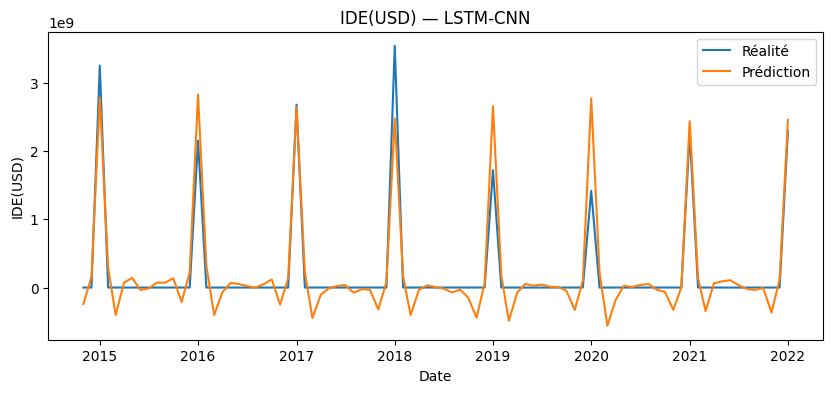

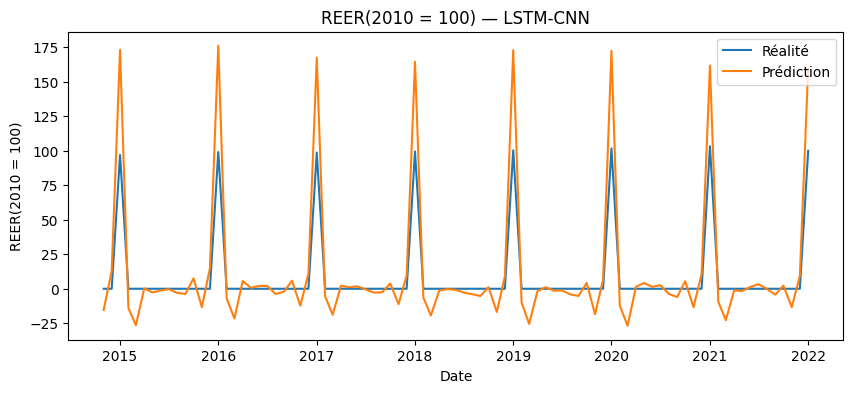

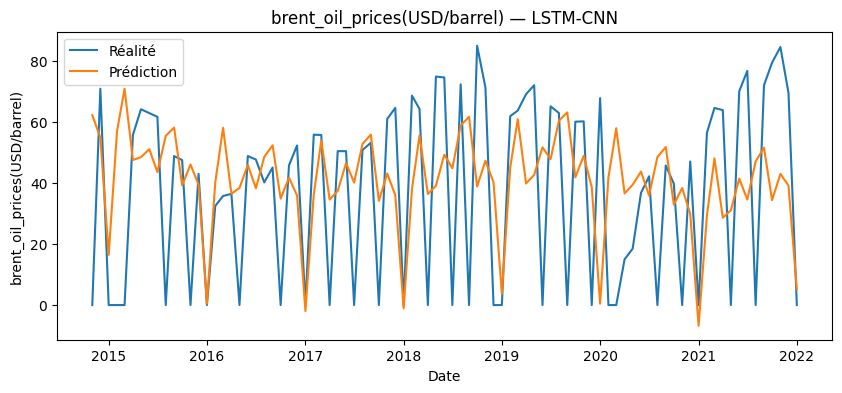

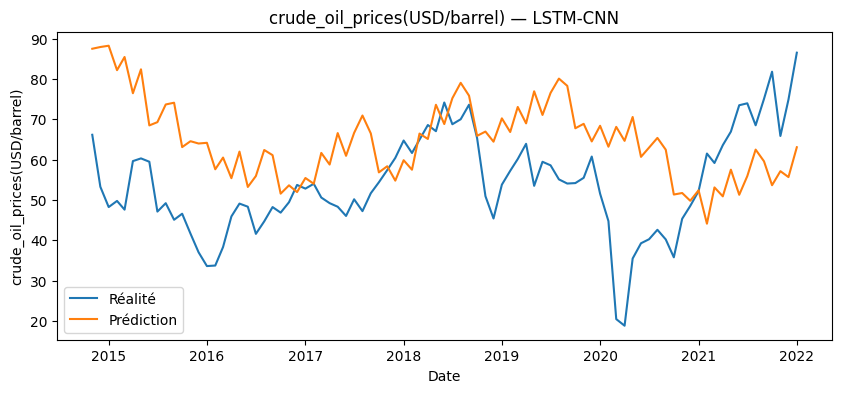

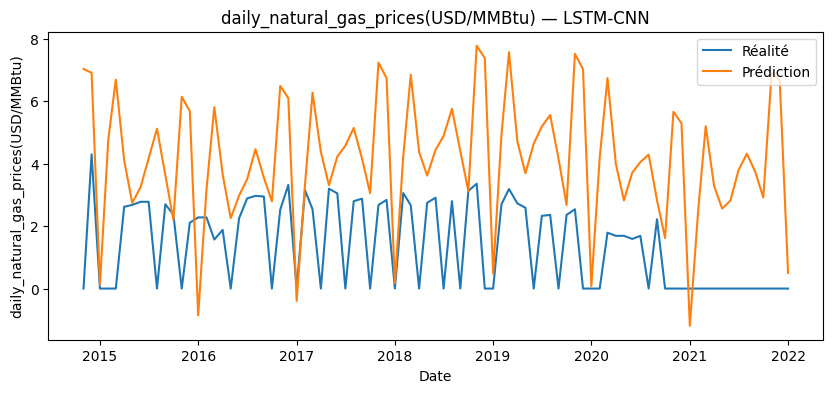

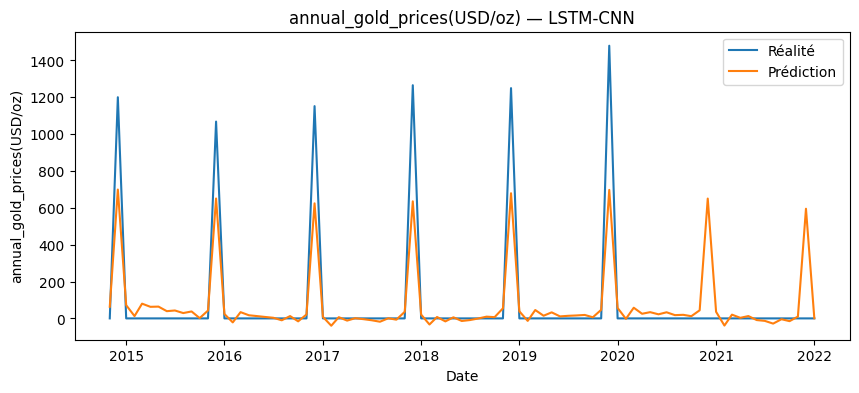

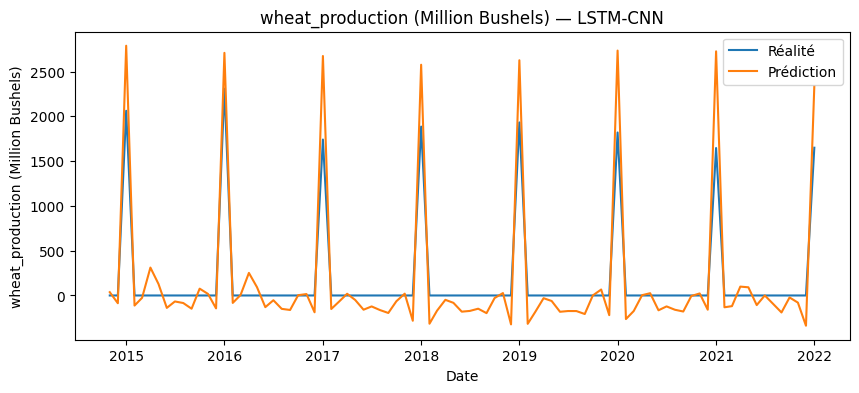

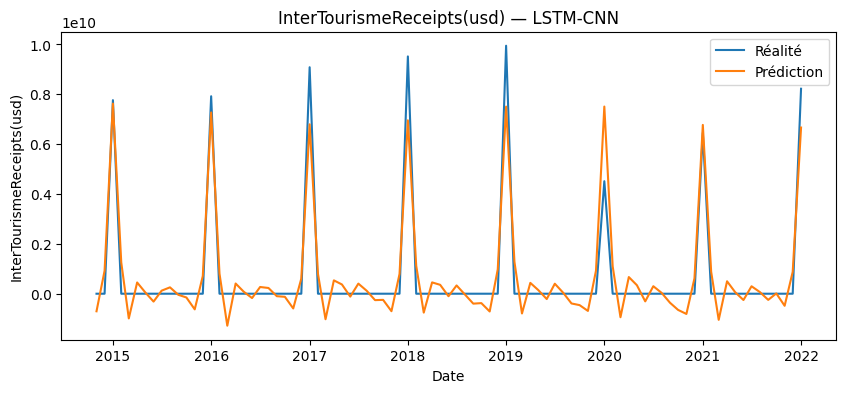

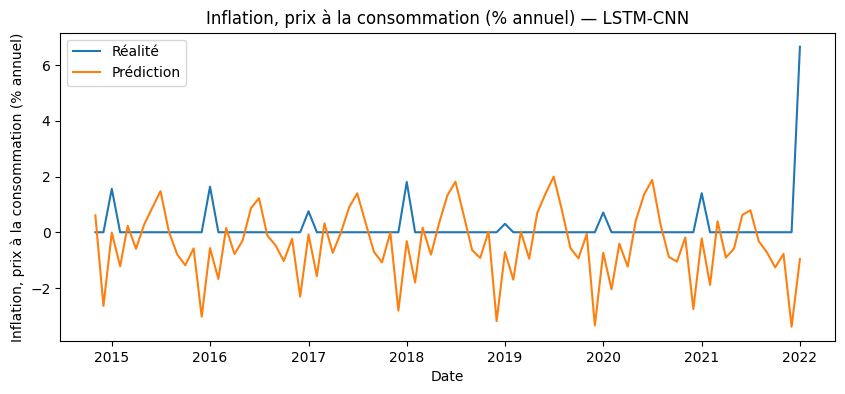

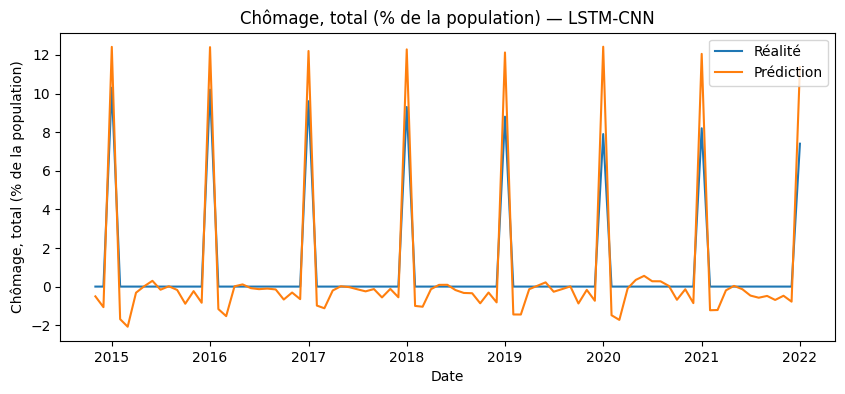

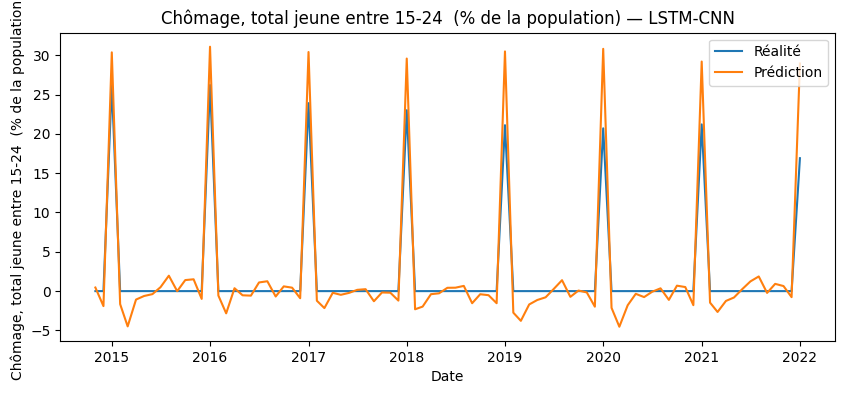

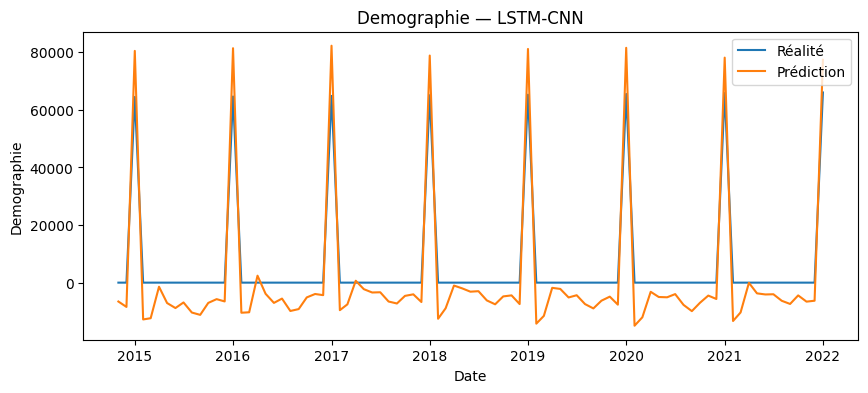

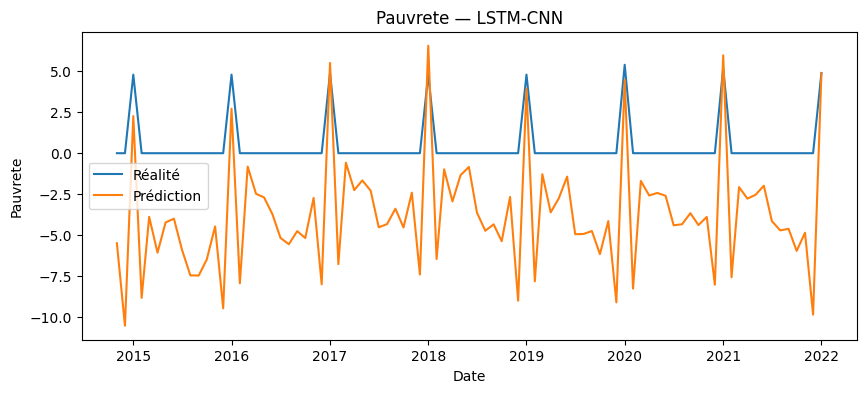

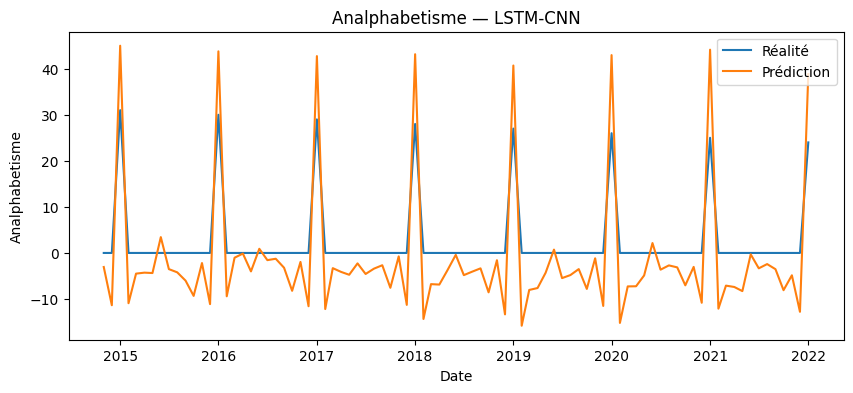

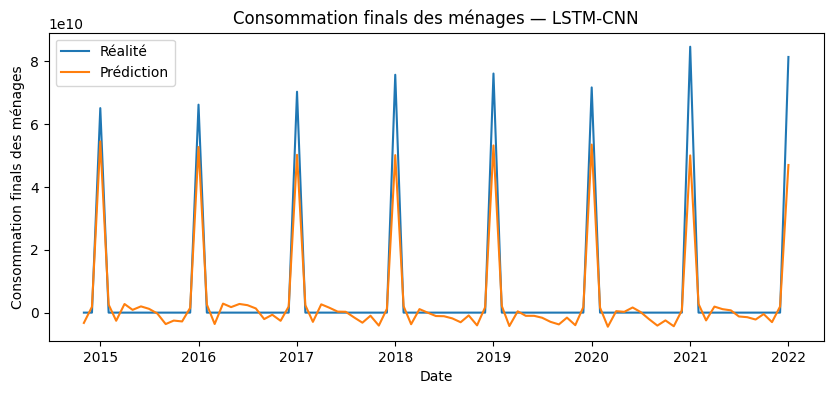

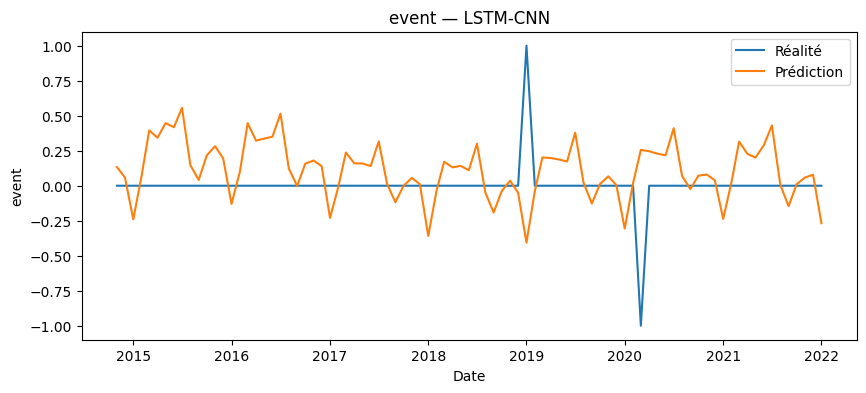

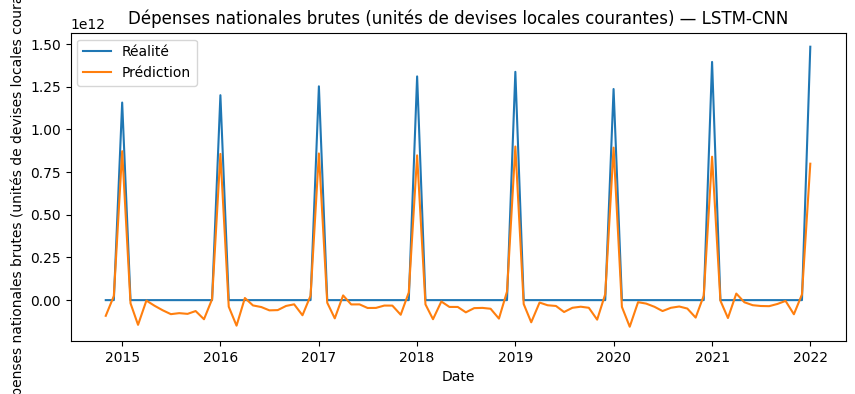

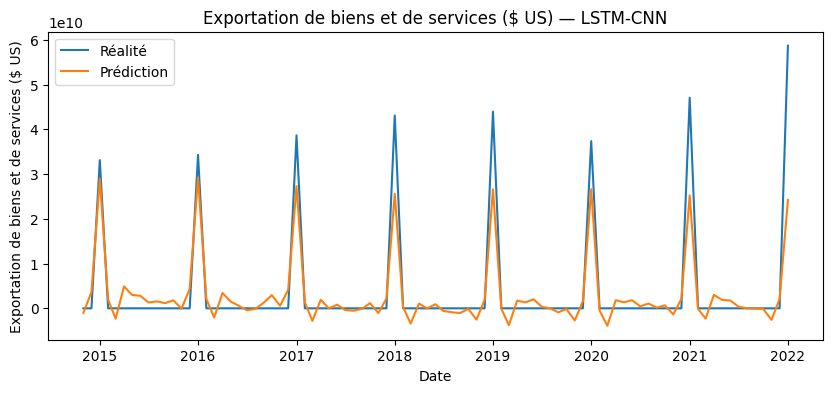

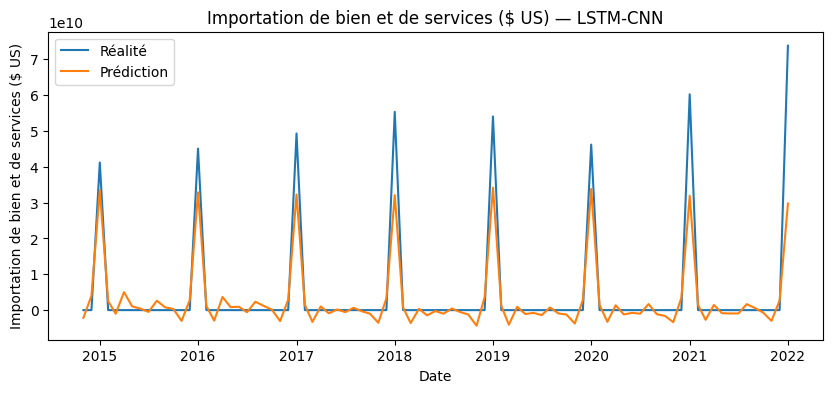

In [36]:
# Cell 17: Visualisation des vraies valeurs vs. prédictions (best model)

import matplotlib.pyplot as plt

# 1) Reconstruction inverse
preds = scaler.inverse_transform(best_model.predict(X_test))
y_true = scaler.inverse_transform(y_test)

# 2) Dates du test : utilisez directement l'index de test_df
dates_test = test_df.index

# 3) Tracé par indicateur
for i, col in enumerate(df.columns):
    plt.figure(figsize=(10, 4))
    plt.plot(dates_test, y_true[:, i], label='Réalité')
    plt.plot(dates_test, preds[:, i], label='Prédiction')
    plt.title(f"{col} — {best_name}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.show()
